# Step 1:
# HGTV SHOW
-HGTV is launching a show based on homes in kings county. The goal of the show is to show homeowners what predictors lead to a higher listing price so the owner can sell and maximize profit.
- 

# IMPORTING LIBRARIES 

In [2]:
#importing the necessary libraries 
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from statsmodels.tools.eval_measures import rmse
from statsmodels.api import qqplot
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from folium.plugins import FastMarkerCluster
import folium
from sklearn.metrics import r2_score

In [4]:
#loading in the data and making a pandas dataframe.
df = pd.read_csv('data/kc_house_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

# EDA(EXPLORITORY DATA ANALYSIS)

In [5]:
#Exploring the columns and values.
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [ ]:
#Exploring some low hanging data.
#some standouts: Avaerage house in this county have 3 bedrooms and 2 bathrooms.
# Theres a hosue in the set that gas 33 bedrooms and 8 bathroom which will defiently be an outlier.
# oldest house is dated to 1900. While he most recent hosue was built in 2015. 
df.describe()
#ON AVERGAE ABOUT 3 BEDROOMS AND 2 BATHROOMS PER HOUSE
# MOST RECENT HOUSE WAS BUILT IN 2015. OLDEST HOUSE WAS BUILT IN 1900

In [ ]:
df.hist(figsize=(20,20));

In [ ]:
#exploring and filtering
#dropping houses that are repeated. some houses are repeated if they had rennovations done.
# Filling in waterfront's NA values with 0 
#dropping years renovated column because a large amount og
df.drop_duplicates(subset='id',keep='first',inplace=True)
df['waterfront'].fillna(0, inplace=True)
df.info()

In [ ]:
for column in list(df.columns):
    print(column, sum(df[column].isnull()))

In [ ]:
drop_vars = ['date','sqft_above', 'sqft_basement',
             'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']
df_corr = df.drop(columns=drop_vars)

# generate heatmap to display correlations
corr = df_corr.corr()
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr, annot=True);


In [ ]:
corr = df.corr().abs()
fig, ax=plt.subplots(figsize=(17,12))
fig.suptitle('Variable Correlations', fontsize=30, y=.95, fontname='Silom')
heatmap = sns.heatmap(corr, cmap='Reds', annot=True)

In [ ]:
features = []
correlations = []
for idx, correlation in corr['price'].T.iteritems():
    if correlation >= .30 and idx != 'price':
        features.append(idx)
        correlations.append(correlation)
corr_with_price = pd.DataFrame({'Correlations':correlations, 'Features': features})

Multicollinear_Features = []
Multicollinear_Corr = []
def check_multicollinearity(feature):
    for idx, correlation in corr[feature].T.iteritems():
        if correlation >= .80 and idx != feature:
            Multicollinear_Features.append([feature, idx])
            Multicollinear_Corr.append(correlation)
            
for feature in corr:
    check_multicollinearity(feature)
MC_df = pd.DataFrame({'Correlations':Multicollinear_Corr, 'Features': Multicollinear_Features})
print('Multicollinear Features')
display(MC_df)
print('Correlations with Price')
display(MC_df)

In [ ]:
plt.figure(figsize=(10,7))
sns.scatterplot(df['view'], df['price'])
plt.title('House View and Price', fontsize=12, fontname='silom')

C:\Users\ilene\anaconda3\envs\learn-env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


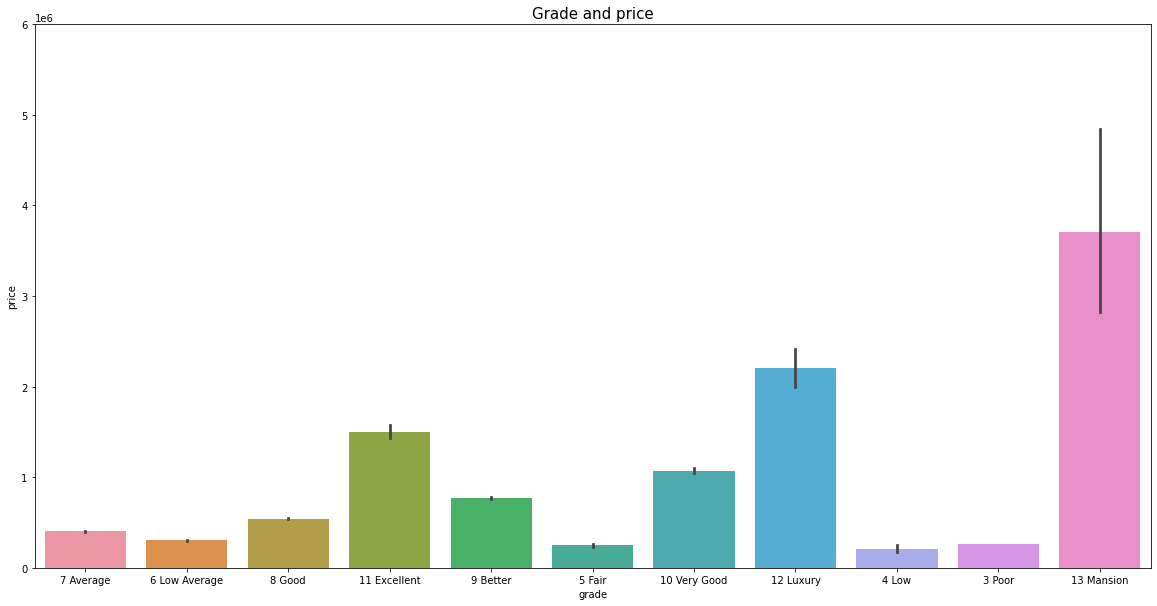

In [13]:
fig, ax = plt.subplots(figsize =(20,10))
y = df['price']
x = df['grade']
sns.barplot(x,y)
ax.set_ylim(bottom=0,top=6000000)
plt.title('Grade and price', fontsize=15, fontname='silom');

#  STEP 2 
# CHECKING  FOR PRE-MODEL ASSUMPTIONS. 

In [ ]:
# CHECKING FOR LINEARITY 


In [ ]:
features = X_train.columns

for x in features:
    plt.scatter(X_train[x], y_train)
    plt.title(f'Plot of Price against {x}')
    plt.xlabel(x)
    plt.ylabel('Price')
    plt.show()
    
# also plot sales against itself
plt.scatter(y_train.index, y_train)
plt.hlines(y_train.mean(), 0, 200)
plt.xlabel('Index Value')
plt.ylabel('Price')
plt.title('Variance of Price')
plt.show()

In [ ]:
train_df = pd.concat([X_train, y_train], axis =1)

In [ ]:
sns.pairplot(train_df)
plt.show()

# STEP 3 TRAIN TEST SPLIT

In [ ]:
y = df.price
X = df[['bedrooms', 'bathrooms', 'sqft_living','sqft_lot','yr_built','grade' ]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

# STEP 4 ONE HOT ENCODE CATEGORICAL VARIABLE

In [ ]:
#grade

In [ ]:
ohe = OneHotEncoder()
ohe.fit_transform(X_train)

In [ ]:
train_df.corr()

# STEP 5 CREATING DUMMY BASELINE

In [ ]:
#Dummy Regressor for the baseline. DUMMY IS ONLY APPLIED ON TRAINING SET
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, y_train)
dummy_regr.predict(X_train)

In [ ]:
dummy_regr.score(X_train, y_train)# the R score is zero.  The mean of Y explains 0% of the variation of sales price. 

In [ ]:
# NEXT BUILD FIRST SIMPLE MODEL THAT DOES BETTER THAN THE DUMMY REGRESSOR. WHICH WAS 0
# CAN USE THE 

In [ ]:
y_train.shape
y_train

# RUNNING A SIMPLE MODEL WTIH VARIABLES []. THESE VARIBALES WERE CHOSEN BASED ON RFE OR VARS THAT ARE HIGHLY CORRELATED WITH SALES.

In [ ]:
# NOW CREATE FIRST SIMPLE MODEL THAT DOES BETTER THAN DUMMY REGRESSOR MEAN.
#EXAMPLES; RECURSIVE FEATURE ELIMINATION. LOOK AT HIGH CORRELATIONS VARIABLES TO Y.

#MODEL 1

In [ ]:
y = df.price
X = df[['bedrooms', 'bathrooms', 'sqft_living','sqft_lot','yr_built','grade', 'floors' ]]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42) 

In [ ]:
dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, y_train)
dummy_regr.predict(X_train)

In [ ]:
dummy_regr.score(X_train, y_train)

In [ ]:
grade_trial = pd.DataFrame()
grade_test = pd.DataFrame()

In [ ]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
grade_trial['grade'] = X_train['grade']
grade_trial['ID'] = len(X_train.values)
ohe_data = pd.DataFrame(ohe.fit_transform(grade_trial)) 
#grade_trial
ohe_data.columns = ohe.get_feature_names(['grade', 'ID'])
ohe_data = ohe_data.drop('ID_17136', axis=1)
#ohe_data

grade_test['grade'] = X_test['grade']
grade_test['ID'] = len(X_test.values)
ohe_test = pd.DataFrame(ohe.transform(grade_test))
ohe_test.columns = ohe.get_feature_names(['grade', 'ID'])
ohe_test = ohe_test.drop('ID_17136', axis=1)

In [ ]:
np.random.seed(42)

y = df.price
X = df[['bedrooms', 'bathrooms', 'sqft_living','sqft_lot','yr_built','grade', 'floors' ]]

# Train test split with random_state=42 and test_size=0.2

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# Scale appropriately on TRAINING DATA 

ss = StandardScaler()
ss.fit(X_train.drop('grade', axis=1))
Testpreds = ss.transform(X_test.drop('grade', axis=1))
X_preds_st_scaled = ss.transform(X_train.drop('grade', axis=1))

lr = LinearRegression()

# fit and score the model (checkout the test set if there is time)
lr.fit(X_preds_st_scaled, y_train)
lr.coef_
lr.score(X_preds_st_scaled, y_train)

In [ ]:
combined_x = ohe_data.join(pd.DataFrame(X_preds_st_scaled))
combined_test = ohe_test.join(pd.DataFrame(Testpreds))

In [ ]:
type(combined_test)

In [191]:
lr = LinearRegression()

# fit and score the model (checkout the test set if there is time)
lr.fit(combined_x.values, y_train)
lr.coef_
lr.score(combined_x.values, y_train)

In [193]:
model1 = lr.predict(combined_test.values)
lr.coef_
lr.score(combined_test.values, y_test)

0.631394848951186

In [189]:
def sk_metrics(y, model):
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    print("Metrics:")
    # R2
    print(f"R2: {r2_score(y, model):.3f}")
    # MAE
    print(f"Mean Absolute Error: {mean_absolute_error(y, model):.3f}")
    # MSE
    print(f"Mean Squared Error: {mean_squared_error(y, model):.3f}")
    # RMSE - just MSE but set squared=False
    print(f"Root Mean Squared Error: {mean_squared_error(y, model, squared=False):.3f}")
    return

In [194]:
sk_metrics(y_test, model1)

Metrics:
R2: 0.631
Mean Absolute Error: 136806.208
Mean Squared Error: 44636756425.438
Root Mean Squared Error: 211274.126


In [ ]:
display(X_train.head())
display(X_test.head())


In [ ]:
# SECOND MODEL

In [ ]:
Model_2 = ols(formula="price ~bathrooms + bedrooms", data=df).fit()
Model_2.summary()


In [ ]:
Model_2 = ols(formula="price ~sqft_living + sqft_living15 ", data=df).fit()
Model_2.summary()S

In [ ]:
Model_3 = ols(formula="price ~sqft_living + sqft_living15 ", data=df).fit()

# KEY TAKEWAYS 